In [1]:
#dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
#create engine to connect to sqlite file
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [6]:
#reflect an existing database into a new model
Base = automap_base()
Base.prepare (engine, reflect = True)

#reflect the tables
Base.classes.keys()

['measurement', 'station']

In [7]:
#save references to each table
meas = Base.classes.measurement
statn = Base.classes.station

#inspect tables for column names
inspector = inspect (engine)

# inspector.get_columns ('measurement')
#returns ('id', int, PK), ('station', str), ('date', str), ('prcp', float), ('tobs', float)

# inspector.get_columns ('station')
#returns ('id', int, PK), ('station', str), ('name', str), ('latitude', float), ('longitude', float), ('elevation', float)

In [8]:
#create session from python to database
session = Session (bind = engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'precipitation (in)')

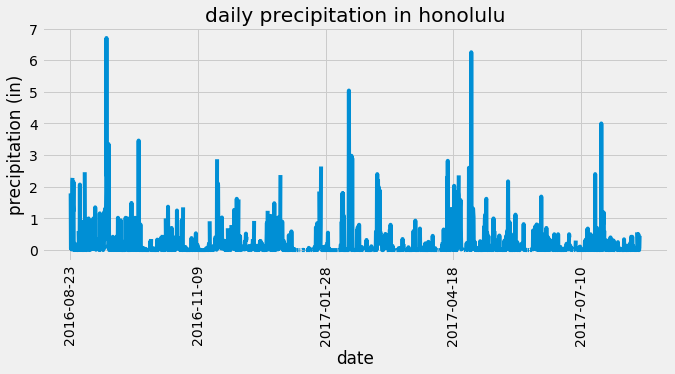

In [9]:
#retrieve last 12 months of precipitation data, plot results

#find most recent date in dataset
last_date = session.query (meas.date).order_by (meas.date.desc()).first()[0]
#print (last_date) = 2017-08-23

#convert date to datetime format, calculate one year (365 days) prior to last day, reformat
last_date_fm = dt.datetime.strptime (last_date, '%Y-%m-%d')
first_date_fm = last_date_fm - dt.timedelta (days = 365)
first_date = first_date_fm.strftime ('%Y-%m-%d')
#print (first_date) = 2016-08-23

#query data, filter dates only from last year
prcp_data = session.query (meas.date, meas.prcp).filter (meas.date >= first_date).all()

#populate dataframe, set date as index & sort
prcp_df = pd.DataFrame (prcp_data,
                        columns = ['date', 'precipitation'])

prcp_df.set_index ('date', inplace = True)
prcp_df = prcp_df.sort_index()

#plot precipitation data w/ pandas plot
prcp_df.plot (rot = 90,
              title = 'daily precipitation in honolulu',
              legend = False,
              figsize = (10,4))

#label y-axis
plt.ylabel ('precipitation (in)')

In [10]:
#calculate dataframe summary statistics
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
#query station data to find # of stations
session.query (statn).count()

9

In [12]:
#list most active stations & row counts in descending order

#query station data, group & order accordingly
statn_data = session.query (meas.station, func.count (meas.station)).\
             group_by (meas.station).\
             order_by (func.count (meas.station).desc()).all()

statn_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
#calculate lowest, highest, & avg temp of most active station
#tobs = temp @ time of observation bias

#pull most active station from previous cell
top_station = statn_data[0][0]

#query data for top station, pull quantitative measures w/ func fxn
top_statn_temps = session.query (func.min(meas.tobs), func.max(meas.tobs), func.avg(meas.tobs)).\
                  filter_by (station = top_station).all()

#print results
print (f"""min: {top_statn_temps[0][0]}
max: {top_statn_temps[0][1]}
avg: {top_statn_temps[0][2]}""")

min: 54.0
max: 85.0
avg: 71.66378066378067


Text(0.5, 0, 'temperature')

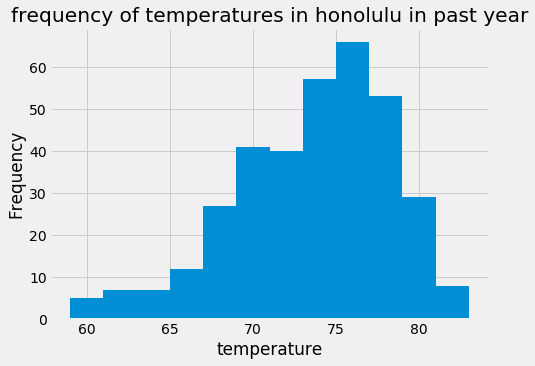

In [14]:
#query top station's last 12 months of temps, plot as histogram

#query measurement table for dates & temps
recent_temps = session.query (meas.date, meas.tobs).\
                              filter (meas.date >= first_date).\
                              filter_by (station = top_station).all()

#populate dataframe, set column names
recent_temp_df = pd.DataFrame (recent_temps,
                               columns = ['date', 'temp (F)'])

#plot histogram w/ pandas plot
recent_temp_df.plot.hist (bins = 12,
                          title = 'frequency of temperatures in honolulu in past year',
                          legend = False,
                          figsize = (7, 5))

#label x-axis
plt.xlabel ('temperature')

## Bonus Challenge Assignment

In [15]:
#part 1: is there a meaningful difference between temps in june vs. temps in december?

#create lists for temp samples for both months
jun_temp_list = []
dec_temp_list = []

#query data for june & december
jun_temps = session.query(meas.tobs).\
            filter(func.strftime("%m", meas.date) == '06').all()

dec_temps = session.query(meas.tobs).\
            filter(func.strftime("%m", meas.date) == '12').all()

#loop through query, append temps to respective lists
for row in jun_temps:
    jun_temp_list.append (row[0])

for row in dec_temps:
    dec_temp_list.append (row[0])
    
#calculate means of both samples
jun_avg_temp = np.mean (jun_temp_list)
dec_avg_temp = np.mean (dec_temp_list)

#print to console
print (f"""jun avg temp: {jun_avg_temp}
dec avg temp: {dec_avg_temp}""")

jun avg temp: 74.94411764705882
dec avg temp: 71.04152933421226


In [16]:
#import scipy stats for t-test
import scipy.stats as st

#conduct independent 2-sample t-test; should be unpaired since hawaii is under two separate 'conditions'
st.ttest_ind (jun_temp_list, dec_temp_list)

#p-value < 0.05, suggesting a significant difference b/w both samples

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

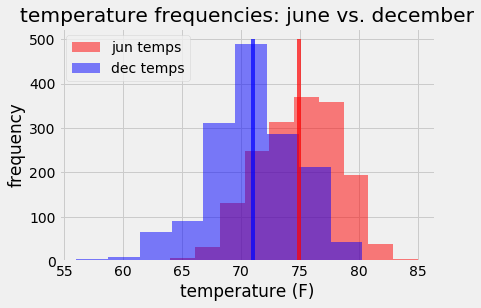

In [17]:
#plot histograms for both sets of temps
plt.hist (jun_temp_list,
          color = 'r',
          alpha = 0.5,
          label = 'jun temps')

plt.hist (dec_temp_list,
          color = 'b',
          alpha = 0.5,
          label = 'dec temps')

#draw vertical lines of respective average temps for june & december
plt.vlines (x = (jun_avg_temp, dec_avg_temp),
            ymin = 0,
            ymax = 500,
            colors = ('r', 'b'),
            alpha = 0.7)

#label axes & title
plt.xlabel ('temperature (F)')
plt.ylabel ('frequency')
plt.title ('temperature frequencies: june vs. december')

#create legend
plt.legend (loc = 'upper left')

#part 1 conclusion: there is a statistically significant, visually confirmable difference in temperatures in june vs. december.

In [18]:
#part 2:

#provided fxn that calculates min, max, & avg temps for selected dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(meas.tobs), func.avg(meas.tobs), func.max(meas.tobs)).\
        filter(meas.date >= start_date).filter(meas.date <= end_date).all()

#function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
#use 'calc_temps' fxn to calculate min, avg, & max temps for selected vacation dates
trip_start = '2016-12-05'
trip_end = '2016-12-15'

[(tmin, tavg, tmax)] = calc_temps(trip_start, trip_end)

#print to console
print (f"""min: {tmin}
avg: {tavg}
max: {tmax}""")

min: 62.0
avg: 69.80555555555556
max: 78.0


Text(0, 0.5, 'temperature (F)')

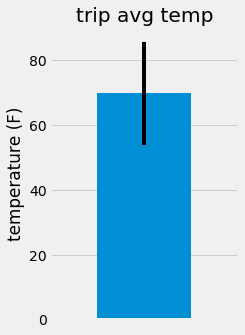

In [20]:
#create dataframe to use w/ pandas plot
tavg_df = pd.DataFrame ({'avg_temp': [tavg]})

#plot single bar
tavg_df.plot.bar (yerr = (tmax - tmin),
                  legend = False,
                  title = 'trip avg temp',
                  figsize = (3, 5))

#remove extraneous xtick
plt.xticks([], [])

#label y-axis
plt.ylabel ('temperature (F)')

In [21]:
#total amount of rainfall per weather station for selected trip dates
#sort in descending order by precipitation amount; list station, name, lat, lng, & elevation

trip_prcp_data = session.query (statn.station, statn.name, statn.latitude, statn.longitude, statn.elevation, func.sum (meas.prcp)).\
                                filter(meas.station == statn.station).\
                                filter(meas.date >= trip_start).\
                                filter(meas.date <= trip_end).\
                                group_by (meas.station).\
                                order_by (func.sum (meas.prcp).desc()).all()

#populate dataframe
pd.DataFrame (trip_prcp_data,
              columns = ('station id', 'station name', 'latitude', 'longitude', 'elevation', 'total prcp (in)'))

,station id,station name,latitude,longitude,elevation,total prcp (in)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.70
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.84
2,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.18
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.12
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.01
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.79
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.29


In [22]:
#provided fxn that queries min, max, & avg temps for a specified day & month in past years
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(meas.tobs), func.avg(meas.tobs), func.max(meas.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", meas.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
#calculate daily normals for the trip

#use previously defined start & end dates to create range of dates
trip_start_fm = dt.datetime.strptime (trip_start,'%Y-%m-%d')
trip_end_fm = dt.datetime.strptime (trip_end,'%Y-%m-%d')

trip_length = trip_end_fm - trip_start_fm
trip_length

#loop through dates, remove year, append dates to list
trip_dates = []

for x in range(trip_length.days + 1):
    ymd = trip_start_fm + dt.timedelta (days = x)
    md = ymd.strftime ('%m-%d')
    trip_dates.append (md)

#create new list for daily normal values
normals = []

#loop through list of trip dates, use previous fxn to calculate respective daily normals, append to list
for day in trip_dates:
    trip_normal = daily_normals (day)
    normals.append (trip_normal[0])

normals

[(64.0, 70.92156862745098, 78.0),
 (61.0, 69.3921568627451, 78.0),
 (58.0, 69.2, 79.0),
 (60.0, 70.27450980392157, 83.0),
 (64.0, 71.90196078431373, 80.0),
 (61.0, 71.24528301886792, 78.0),
 (64.0, 72.38775510204081, 78.0),
 (64.0, 70.88235294117646, 79.0),
 (65.0, 70.9423076923077, 80.0),
 (65.0, 71.18, 78.0),
 (62.0, 71.34, 79.0)]

In [24]:
#push query data to dataframe
normals_df = pd.DataFrame (normals,
                           columns = ('min temp', 'avg temp', 'max temp'))

#add dates as a column, set as index
normals_df['date'] = trip_dates
normals_df.set_index ('date', inplace = True)

normals_df

,min temp,avg temp,max temp
date,,,
12-05,64.0,70.921569,78.0
12-06,61.0,69.392157,78.0
12-07,58.0,69.200000,79.0
12-08,60.0,70.274510,83.0
12-09,64.0,71.901961,80.0
12-10,61.0,71.245283,78.0
12-11,64.0,72.387755,78.0
12-12,64.0,70.882353,79.0
12-13,65.0,70.942308,80.0


Text(0, 0.5, 'temperature (F)')

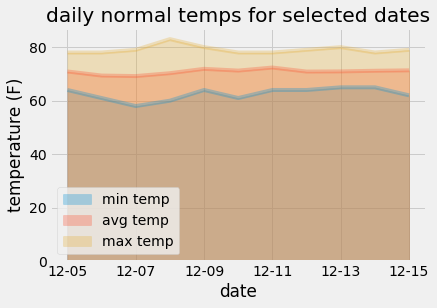

In [25]:
#plot dataframe w/ area plot, stacked = False
normals_df.plot.area (stacked = False,
                      alpha = 0.3,
                      title = 'daily normal temps for selected dates')

#label y-axis
plt.ylabel ('temperature (F)')